<a href="https://colab.research.google.com/github/brepowell/ML-Contest-Series/blob/main/MLSeriesSupervisedLearningTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To run:
Use an IDE that will allow you to open a Jupyter Notebook.

For example, use Anaconda Navigator to open Visual Studio Code.

You may need to select a kernel to run the program.

# DATA GATHERING

## Import Libraries

In [1441]:
# This step can be done in any cell of the notebook. It does not have to be at the top.
import pandas as pd


## Data Information

From:
https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

More Info:
https://innovation.ukpowernetworks.co.uk/projects/low-carbon-london

"Created 9 years ago, updated 2 years ago
Energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014.

Readings were taken at half hourly intervals. The customers in the trial were recruited as a balanced sample representative of the Greater London population.

The dataset contains energy consumption, in kWh (per half hour), unique household identifier, date and time. The CSV file is around 10GB when unzipped and contains around 167million rows.

Within the data set are two groups of customers. The first is a sub-group, of approximately 1100 customers, who were subjected to Dynamic Time of Use (dToU) energy prices throughout the 2013 calendar year period. The tariff prices were given a day ahead via the Smart Meter IHD (In Home Display) or text message to mobile phone. Customers were issued High (67.20p/kWh), Low (3.99p/kWh) or normal (11.76p/kWh) price signals and the times of day these applied. The dates/times and the price signal schedule is availaible as part of this dataset. All non-Time of Use customers were on a flat rate tariff of 14.228pence/kWh.

The signals given were designed to be representative of the types of signal that may be used in the future to manage both high renewable generation (supply following) operation and also test the potential to use high price signals to reduce stress on local distribution grids during periods of stress.

The remaining sample of approximately 4500 customers energy consumption readings were not subject to the dToU tariff."


## Load Data -- Daily

In [1442]:
# Use Pandas to load the data into a dataframe
path = "data/archive/"
startYear = 2011   # 2011-11-23	is the earliest day I can find in the dataset
endYear = 2014     # 2014-02-28 is the last day I can find in the dataset

londonData = pd.read_csv(path + 'daily_dataset.csv')
londonData.shape


(3510433, 9)

## Load Data -- Half Hourly

In [1443]:
# tstp = Time Series Time Period (day)
# This shows readings every half hour (LCLid + tstp + energy(kWh/hh) = 3 columns)
path = "data/archive/halfhourly_dataset/halfhourly_dataset/"
block1 = pd.read_csv(path + 'block_0.csv')
block1.shape


(1222670, 3)

## Load Data -- Half Hourly 2nd set

In [1444]:
# This shows readings every half hour (LCLid + day + 48 half hour columns = 50 columns) per day, per ID
# It is the same data as the halfhourly_dataset, except formatted differently and with more precision.
path = "data/archive/hhblock_dataset/hhblock_dataset/"
halfblock0 = pd.read_csv(path + 'block_0.csv')
halfblock0.shape

(25286, 50)

## Drop Null

In [1445]:
# Drop any row that has null values
# The last day of data collection was showing lots of null values
londonData.dropna(inplace=True)

In [1446]:
# Lost 11,331 rows of data from (3510433, 9)
londonData.shape

(3499102, 9)

# FEATURE EXPLORATION

## Check the Min/Max/Avg -- Daily

In [1447]:
londonData.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [1448]:
londonData.tail() 

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
3510427,MAC004977,2014-02-23,0.1365,0.174646,0.754,48,0.151583,8.383,0.046
3510428,MAC004977,2014-02-24,0.0950,0.118458,0.580,48,0.093814,5.686,0.052
3510429,MAC004977,2014-02-25,0.0675,0.084208,0.176,48,0.037107,4.042,0.046
3510430,MAC004977,2014-02-26,0.1080,0.120500,0.282,48,0.069332,5.784,0.046
3510431,MAC004977,2014-02-27,0.0720,0.114062,0.431,48,0.094482,5.475,0.047


In [1449]:
londonData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3499102 entries, 0 to 3510431
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          object 
 1   day            object 
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 267.0+ MB


In [1450]:
# Zero is the minimum for all except energy_count
londonData.describe()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,3.499102e+06,3.499102e+06,3.499102e+06,3.499102e+06,3.499102e+06,3.499102e+06,3.499102e+06
mean,1.586612e-01,2.118233e-01,8.366252e-01,4.795521e+01,1.726673e-01,1.015625e+01,5.922736e-02
std,1.695142e-01,1.903080e-01,6.681264e-01,8.998640e-01,1.531208e-01,9.125979e+00,8.500841e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e-02,9.827083e-02,3.480000e-01,4.800000e+01,6.911626e-02,4.711000e+00,2.000000e-02
50%,1.145000e-01,1.634583e-01,6.900000e-01,4.800000e+01,1.327910e-01,7.838000e+00,3.900000e-02
75%,1.910000e-01,2.626042e-01,1.130000e+00,4.800000e+01,2.293124e-01,1.259100e+01,7.100000e-02
max,6.970500e+00,6.928250e+00,1.076100e+01,4.800000e+01,4.024569e+00,3.325560e+02,6.394000e+00


In [1451]:
# There are 5566 distinct LCLids (customers) originally - became 5561 with dropping all nulls
customerIDs = londonData.groupby("LCLid").count()
customerIDs.shape

(5561, 8)

## Drop Days

In [1452]:
# There are 828 days in the dataset
allDays = londonData.groupby("day").count()
allDays.shape

(828, 8)

In [1453]:
# The min number of customers for one day is 13 customers
# The max number of customers for one day is 5531 (5541 if don't drop all NaNs)
allDays.describe()["LCLid"]

count     828.000000
mean     4225.968599
std      1789.812851
min        13.000000
25%      4057.000000
50%      5127.500000
75%      5361.750000
max      5531.000000
Name: LCLid, dtype: float64

In [1454]:
# There are fewer customers serviced for the first few days (fewer than 100 customers)
daysDropped = allDays[allDays['LCLid'] <= 100].index
daysDropped

Index(['2011-11-23', '2011-11-24', '2011-11-25', '2011-11-26', '2011-11-27',
       '2011-11-28', '2011-11-29', '2011-11-30', '2011-12-01', '2011-12-02'],
      dtype='object', name='day')

In [1455]:
londonData = londonData[~londonData["day"].isin(daysDropped)]
londonData.shape

(3498564, 9)

In [1456]:
allDays = londonData.groupby("day").count()
allDays.shape

(818, 8)

In [1457]:
allDays.describe()

,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000
mean,4276.973105,4276.973105,4276.973105,4276.973105,4276.973105,4276.973105,4276.973105,4276.973105
std,1739.817825,1739.817825,1739.817825,1739.817825,1739.817825,1739.817825,1739.817825,1739.817825
min,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
25%,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000
50%,5154.500000,5154.500000,5154.500000,5154.500000,5154.500000,5154.500000,5154.500000,5154.500000
75%,5365.500000,5365.500000,5365.500000,5365.500000,5365.500000,5365.500000,5365.500000,5365.500000
max,5531.000000,5531.000000,5531.000000,5531.000000,5531.000000,5531.000000,5531.000000,5531.000000


In [1458]:
londonData.shape

(3498564, 9)

## Drop Customers

In [1459]:
# Without dropping Null values and low days, there were 5 customers that only had one day of information 
# ["MAC001150", "MAC005556", "MAC005559", "MAC005560", "MAC005563"]
# Even after dropping Null values, there is still a customer who has only 2 days of information.
customerIDs.min()

day              2
energy_median    2
energy_mean      2
energy_max       2
energy_count     2
energy_std       2
energy_sum       2
energy_min       2
dtype: int64

In [1460]:
customerIDs = londonData.groupby("LCLid").count()
customersDropped = customerIDs[customerIDs['day'] <= 100].index
customersDropped

Index(['MAC001278', 'MAC001300', 'MAC001653', 'MAC001957', 'MAC002110',
       'MAC003346', 'MAC005565'],
      dtype='object', name='LCLid')

In [1461]:
londonData = londonData[~londonData["LCLid"].isin(customersDropped)]
londonData.shape

(3498343, 9)

In [1462]:
customerIDs = londonData.groupby("LCLid").count()
customerIDs.describe()

,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000
mean,629.878106,629.878106,629.878106,629.878106,629.878106,629.878106,629.878106,629.878106
std,108.230768,108.230768,108.230768,108.230768,108.230768,108.230768,108.230768,108.230768
min,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
25%,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000
50%,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000
75%,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
max,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000


## Power Outage Days

In [1463]:
# There are possibly 15,138 power outages, where max energy was 0 for the day
zeroPower = londonData[londonData['energy_max'] == 0]
zeroPower.shape

(14967, 9)

In [1464]:
# I wonder what energy_count is????
zeroPower.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
12271,MAC004560,2013-04-02,0.0,0.0,0.0,48,0.0,0.0,0.0
12272,MAC004560,2013-04-03,0.0,0.0,0.0,48,0.0,0.0,0.0
12273,MAC004560,2013-04-04,0.0,0.0,0.0,48,0.0,0.0,0.0
41810,MAC001340,2013-11-15,0.0,0.0,0.0,48,0.0,0.0,0.0
41811,MAC001340,2013-11-16,0.0,0.0,0.0,48,0.0,0.0,0.0


In [1465]:
zeroPower.to_csv("PowerOutages.csv")

In [1466]:
# Convert to datetime
zeroPower['day'] = pd.to_datetime(zeroPower['day'])

C:\Users\brely\AppData\Local\Temp\ipykernel_24056\2167483632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeroPower['day'] = pd.to_datetime(zeroPower['day'])


In [1467]:
# There are possibly 819 days where the power was out for at least one location
# After dropping NaN and Days and Customers <= 100, this became 814.
zeroPowerDays = zeroPower.groupby("day").count()
zeroPowerDays.drop(zeroPowerDays.columns.difference(['LCLid']), axis=1, inplace=True)
zeroPowerDays.shape

(814, 1)

In [1468]:
zeroPowerDays.head()

,LCLid
day,
2011-12-04,1
2011-12-05,1
2011-12-06,1
2011-12-07,1
2011-12-08,1


In [1469]:
zeroPowerDays.tail()

,LCLid
day,
2014-02-23,22
2014-02-24,19
2014-02-25,20
2014-02-26,21
2014-02-27,21


### Outlier -- Last Day Large Outage

In [1470]:
# There was a day where 37 customers were without power - that's the largest spread of a blackout
# There was also a day where 1 person was without power - that's the smallest spread of a blackout
zeroPowerDays.describe()

,LCLid
count,814.000000
mean,18.386978
std,9.133229
min,1.000000
25%,13.000000
50%,21.000000
75%,25.000000
max,37.000000


In [1509]:
# There were 104 customers affected by a small outage of fewer than 4 customers
smallOutages = zeroPowerDays[zeroPowerDays["LCLid"] < 4].index
smallOutages.shape

(104,)

In [1515]:
# There were 447 customers affected by larger outages of more than 20 customers
longOutages = zeroPowerDays[zeroPowerDays["LCLid"] > 20].index
longOutages.shape

(447,)

In [1512]:
smallOutages

DatetimeIndex(['2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07',
               '2011-12-08', '2011-12-09', '2011-12-10', '2011-12-11',
               '2011-12-12', '2011-12-13',
               ...
               '2012-03-29', '2012-03-30', '2012-04-04', '2012-04-05',
               '2012-04-10', '2012-04-11', '2012-04-12', '2012-04-14',
               '2012-04-16', '2012-05-01'],
              dtype='datetime64[ns]', name='day', length=104, freq=None)

### Outages Per Year

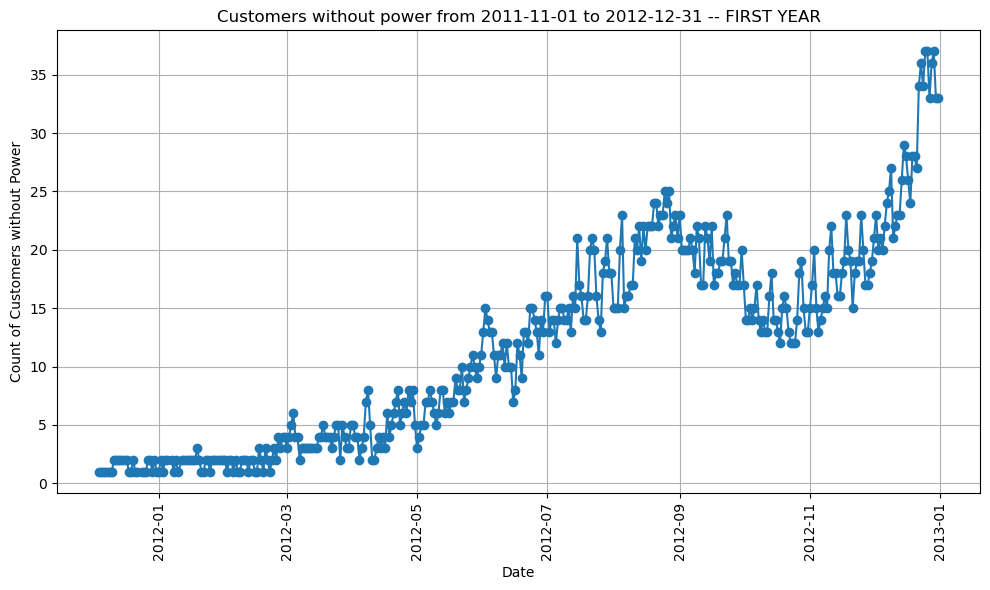

In [1472]:
import matplotlib.pyplot as plt 

# Filter the DataFrame to include only the rows within the specified date range
start_date = '2011-11-01'
end_date = '2012-12-31'
subset_data = zeroPowerDays[start_date:end_date]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(subset_data.index, subset_data['LCLid'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count of Customers without Power')
plt.title('Customers without power from {} to {} -- FIRST YEAR'.format(start_date, end_date))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

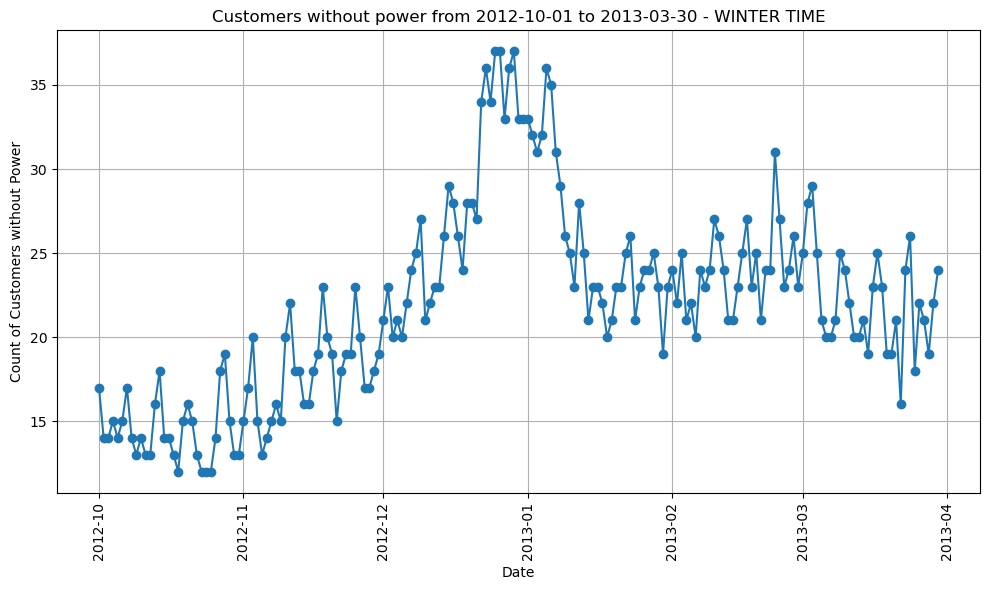

In [1473]:
import matplotlib.pyplot as plt 

# Filter the DataFrame to include only the rows within the specified date range
start_date = '2012-10-01'
end_date = '2013-03-30'
subset_data = zeroPowerDays[start_date:end_date]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(subset_data.index, subset_data['LCLid'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count of Customers without Power')
plt.title('Customers without power from {} to {} - WINTER TIME'.format(start_date, end_date))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

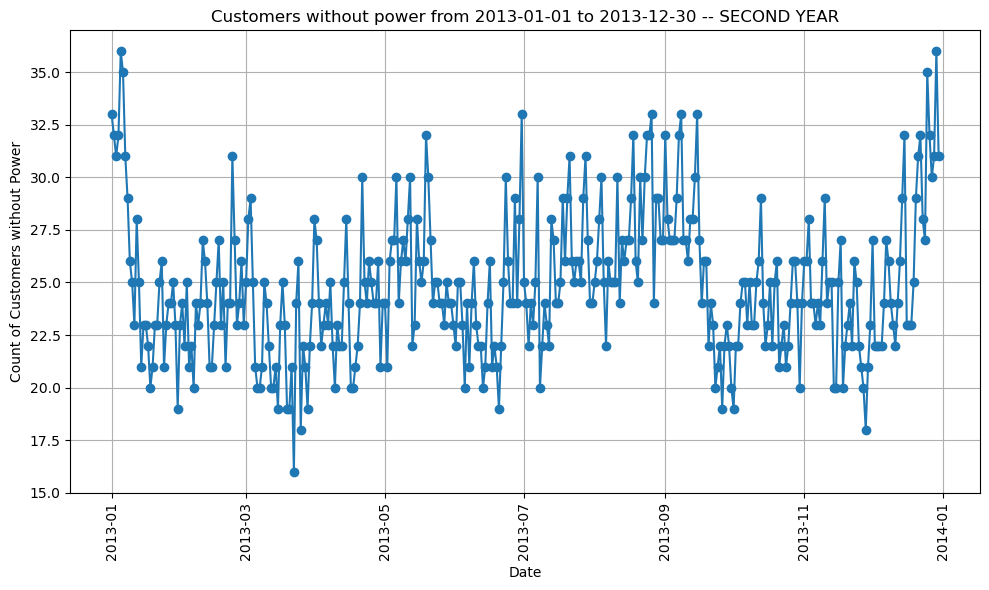

In [1474]:
import matplotlib.pyplot as plt 

# Filter the DataFrame to include only the rows within the specified date range
start_date = '2013-01-01'
end_date = '2013-12-30'
subset_data = zeroPowerDays[start_date:end_date]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(subset_data.index, subset_data['LCLid'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count of Customers without Power')
plt.title('Customers without power from {} to {} -- SECOND YEAR'.format(start_date, end_date))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


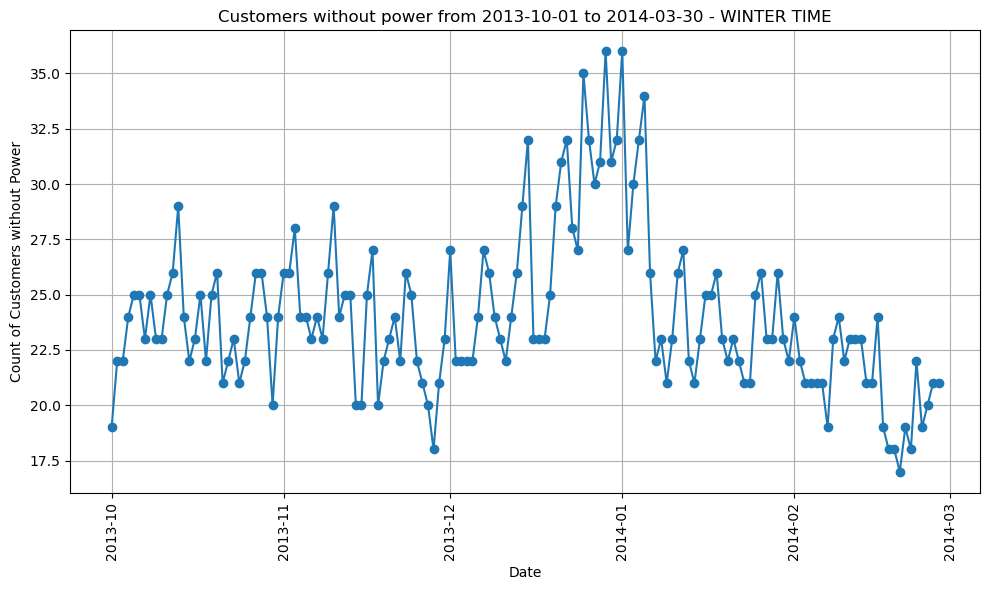

In [1475]:
import matplotlib.pyplot as plt 

# Filter the DataFrame to include only the rows within the specified date range
start_date = '2013-10-01'
end_date = '2014-03-30'
subset_data = zeroPowerDays[start_date:end_date]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(subset_data.index, subset_data['LCLid'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count of Customers without Power')
plt.title('Customers without power from {} to {} - WINTER TIME'.format(start_date, end_date))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

### Power Outage Customers

In [1476]:
# There are possibly 281 customers affected by at least 1 power outage over the whole data collection period
# This went down to 225 after additional pre-processing.
zeroPowerIDs = zeroPower.groupby("LCLid").count()
zeroPowerIDs.shape

(225, 8)

In [1477]:
zeroPowerIDs.drop(zeroPowerIDs.columns.difference(['day']), axis=1, inplace=True)
zeroPowerIDs.head()


,day
LCLid,
MAC000037,640
MAC000041,17
MAC000042,30
MAC000120,11
MAC000134,144


In [1478]:
zeroPowerIDs.describe()

,day
count,225.000000
mean,66.520000
std,122.961488
min,1.000000
25%,7.000000
50%,23.000000
75%,61.000000
max,782.000000


<Figure size 1000x600 with 0 Axes>

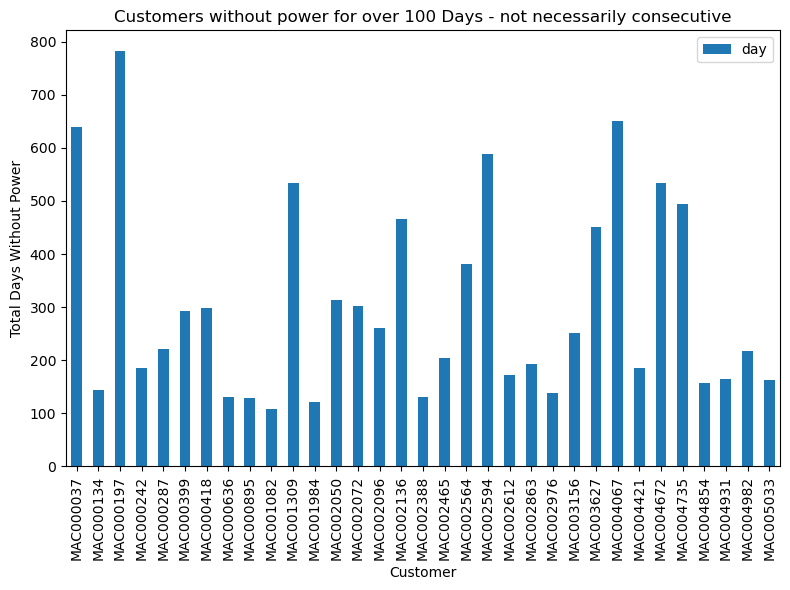

In [1479]:
import matplotlib.pyplot as plt 

zeroPowerIDs_filtered = zeroPowerIDs[zeroPowerIDs['day'] > 100]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
zeroPowerIDs_filtered.plot(kind='bar')
plt.xlabel('Customer')
plt.ylabel('Total Days Without Power')
plt.title('Customers without power for over 100 Days - not necessarily consecutive')
plt.xticks(rotation=90)  # Rotating x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [1480]:
# There are 33 customers who have over 100 days of power outage during the data collection period.
zeroPowerIDs_filtered.shape

(33, 1)

In [1481]:
zeroPower.sort_values(by=['day'], inplace=True)

C:\Users\brely\AppData\Local\Temp\ipykernel_24056\3317076614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeroPower.sort_values(by=['day'], inplace=True)


In [1482]:
zeroPower.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
2127701,MAC000197,2011-12-04,0.0,0.0,0.0,48,0.0,0.0,0.0
2127702,MAC000197,2011-12-05,0.0,0.0,0.0,48,0.0,0.0,0.0
2127703,MAC000197,2011-12-06,0.0,0.0,0.0,48,0.0,0.0,0.0
2127704,MAC000197,2011-12-07,0.0,0.0,0.0,48,0.0,0.0,0.0
2127705,MAC000197,2011-12-08,0.0,0.0,0.0,48,0.0,0.0,0.0


In [1483]:
zeroPower.tail()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
1215648,MAC002594,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0
2338052,MAC004421,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0
2428915,MAC003627,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0
2229608,MAC002416,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0
1327876,MAC002564,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0


## Customer Information

In [1484]:
# Use Pandas to load the data into a dataframe
path = "data/archive/"
house = pd.read_csv(path + 'informations_households.csv')

In [1485]:
house.shape

(5566, 5)

### Sparse Houses

In [1486]:
# These are the houses that only have one data point collected:
singleton1 = house[house["LCLid"] == "MAC001150"]
singleton2 = house[house["LCLid"] == "MAC005556"]
singleton3 = house[house["LCLid"] == "MAC005559"]
singleton4 = house[house["LCLid"] == "MAC005560"]
singleton5 = house[house["LCLid"] == "MAC005563"]
print(singleton1, singleton2, singleton3, singleton4, singleton5)

          LCLid stdorToU    Acorn Acorn_grouped      file
3333  MAC001150      Std  ACORN-H   Comfortable  block_66           LCLid stdorToU    Acorn Acorn_grouped       file
5496  MAC005556      Std  ACORN-Q     Adversity  block_109           LCLid stdorToU    Acorn Acorn_grouped      file
3698  MAC005559      Std  ACORN-J   Comfortable  block_73           LCLid stdorToU    Acorn Acorn_grouped      file
4633  MAC005560      Std  ACORN-P     Adversity  block_92           LCLid stdorToU    Acorn Acorn_grouped       file
5498  MAC005563      Std  ACORN-Q     Adversity  block_109


In [1487]:
path = "data/archive/hhblock_dataset/hhblock_dataset/"
hblock66 = pd.read_csv(path + 'block_66.csv')

### Dead House

In [1488]:
# Looking at that house that was dead for a long time
house[house["LCLid"] == "MAC001340"]

,LCLid,stdorToU,Acorn,Acorn_grouped,file
4394,MAC001340,Std,ACORN-N,Adversity,block_87


In [1489]:
path = "data/archive/hhblock_dataset/hhblock_dataset/"
halfblock87 = pd.read_csv(path + 'block_87.csv')

In [1490]:
deadHouse = halfblock87[halfblock87["LCLid"] == "MAC001340"]
deadHouse.set_index(deadHouse['day'], inplace=True)
deadHouse.drop("LCLid", axis=1, inplace=True)
deadHouse.drop("day", axis=1, inplace=True)
deadHouse.shape

C:\Users\brely\AppData\Local\Temp\ipykernel_24056\1727719763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadHouse.drop("LCLid", axis=1, inplace=True)
C:\Users\brely\AppData\Local\Temp\ipykernel_24056\1727719763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadHouse.drop("day", axis=1, inplace=True)


(646, 48)

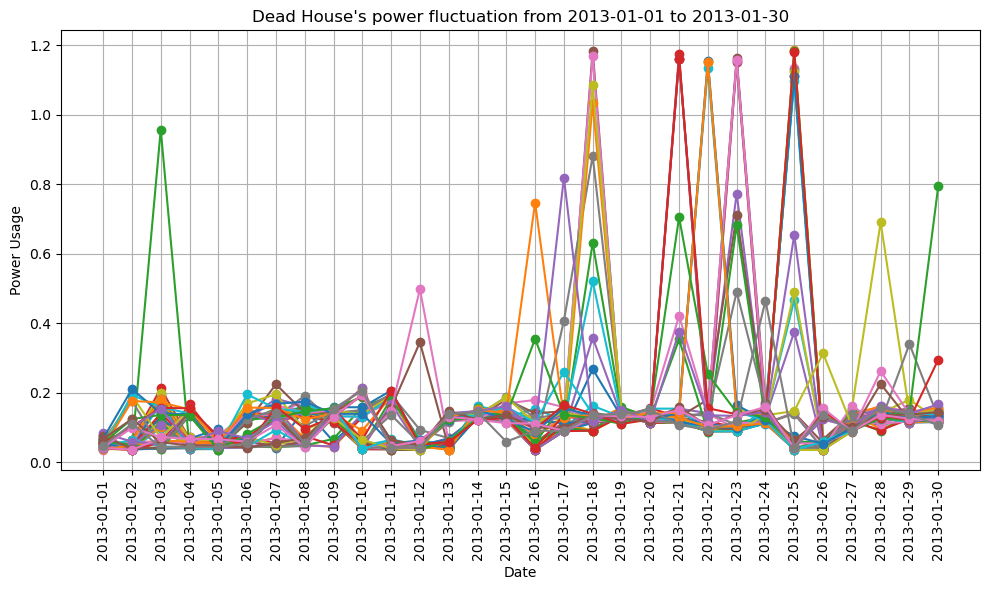

In [1491]:
import matplotlib.pyplot as plt 

# Filter the DataFrame to include only the rows within the specified date range
start_date = '2013-01-01'
end_date = '2013-01-30'
subset_data = deadHouse[start_date:end_date]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(subset_data, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Power Usage')
plt.title('Dead House\'s power fluctuation from {} to {}'.format(start_date, end_date))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


### Dead House 2

In [1492]:
house[house["LCLid"] == "MAC000197"]

,LCLid,stdorToU,Acorn,Acorn_grouped,file
2399,MAC000197,Std,ACORN-F,Comfortable,block_47


In [1493]:
path = "data/archive/hhblock_dataset/hhblock_dataset/"
halfblock47 = pd.read_csv(path + 'block_47.csv')

deadHouse = halfblock47[halfblock47["LCLid"] == "MAC000197"]
deadHouse.set_index(deadHouse['day'], inplace=True)
deadHouse.drop("LCLid", axis=1, inplace=True)
deadHouse.drop("day", axis=1, inplace=True)
deadHouse.shape

C:\Users\brely\AppData\Local\Temp\ipykernel_24056\875155919.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadHouse.drop("LCLid", axis=1, inplace=True)
C:\Users\brely\AppData\Local\Temp\ipykernel_24056\875155919.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadHouse.drop("day", axis=1, inplace=True)


(817, 48)

In [1494]:
import matplotlib.pyplot as plt 

# Filter the DataFrame to include only the rows within the specified date range
start_date = '2013-01-01'
end_date = '2013-01-30'
subset_data = deadHouse[start_date:end_date]

subset_data.max()[subset_data.max() != 0]

hh_24    0.180
hh_25    0.541
hh_26    0.526
hh_27    0.553
hh_28    0.554
hh_29    0.504
hh_30    0.529
hh_31    0.824
hh_32    0.596
hh_33    0.562
hh_34    0.557
hh_35    0.567
hh_36    0.571
hh_37    0.576
hh_38    0.578
hh_39    0.053
hh_40    0.258
hh_41    0.074
dtype: float64

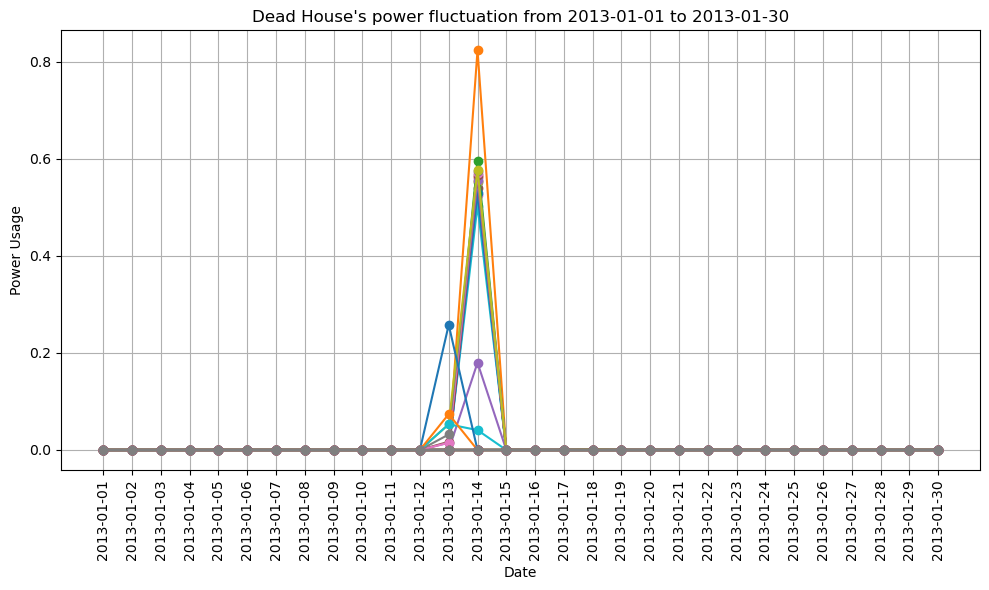

In [1495]:


# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(subset_data, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Power Usage')
plt.title('Dead House\'s power fluctuation from {} to {}'.format(start_date, end_date))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

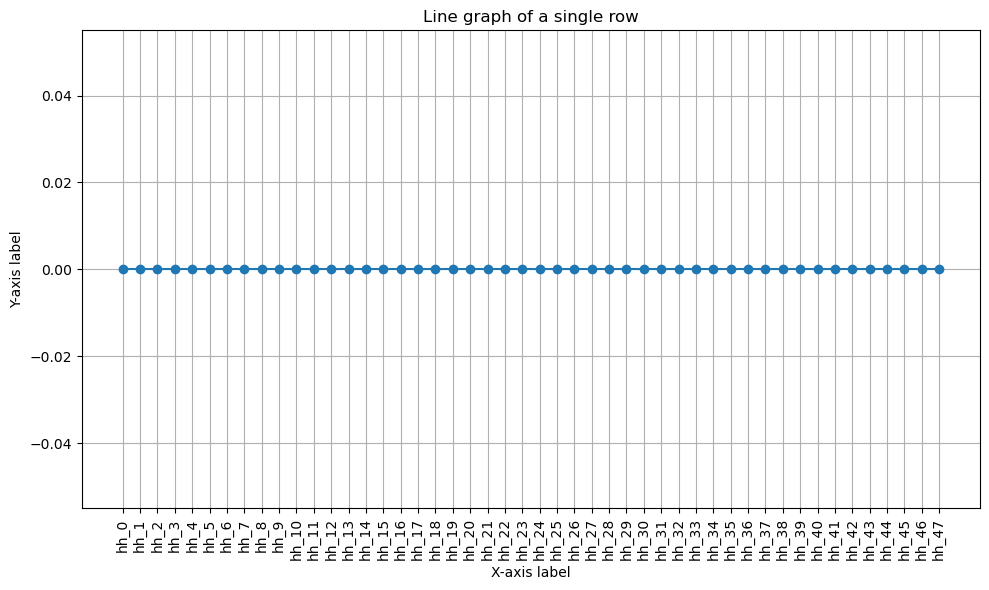

In [1496]:
import matplotlib.pyplot as plt

# Assuming londonData is your DataFrame and 'row_index' is the index of the row you want to plot
row = deadHouse.iloc[0]

# Plotting the line graph for the selected row
plt.figure(figsize=(10, 6))
plt.plot(row, marker='o', linestyle='-')
plt.xlabel('X-axis label')  # Replace 'X-axis label' with the appropriate label
plt.ylabel('Y-axis label')  # Replace 'Y-axis label' with the appropriate label
plt.title('Line graph of a single row')  # Replace 'Line graph of a single row' with the appropriate title
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Check the Min/Max/Avg -- 1/2 Hourly

In [1497]:
block1.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00.0000000,0
1,MAC000002,2012-10-12 01:00:00.0000000,0
2,MAC000002,2012-10-12 01:30:00.0000000,0
3,MAC000002,2012-10-12 02:00:00.0000000,0
4,MAC000002,2012-10-12 02:30:00.0000000,0


In [1498]:
block1.tail()

,LCLid,tstp,energy(kWh/hh)
1222665,MAC005492,2014-02-27 22:00:00.0000000,0.182
1222666,MAC005492,2014-02-27 22:30:00.0000000,0.122
1222667,MAC005492,2014-02-27 23:00:00.0000000,0.14
1222668,MAC005492,2014-02-27 23:30:00.0000000,0.192
1222669,MAC005492,2014-02-28 00:00:00.0000000,0.088


In [1499]:
block1.describe()

,LCLid,tstp,energy(kWh/hh)
count,1222670,1222670,1222670
unique,50,39292,5022
top,MAC000246,2012-12-16 00:00:00.0000000,0.013
freq,39245,50,6238


In [1500]:
# The halfhourly block files only show around 50 locations, due to the granularity of half hour
hourlycustomerIDs = block1.groupby("LCLid").count()
hourlycustomerIDs.shape

(50, 2)

## Visualize the features

In [1501]:
#https://www.tensorflow.org/tutorials/structured_data/time_series

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

df = londonData
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::366]

df.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
5,MAC000131,2011-12-20,0.2180,0.357500,1.077,48,0.287597,17.160,0.066
371,MAC000131,2012-12-20,0.1235,0.223292,0.757,48,0.225641,10.718,0.065
737,MAC000131,2013-12-21,0.1010,0.168958,0.732,48,0.180904,8.110,0.065
1104,MAC000132,2012-10-07,0.2140,0.325250,1.300,48,0.286319,15.612,0.042
1470,MAC000132,2013-10-08,0.2070,0.295187,0.987,48,0.207083,14.169,0.070


In [1502]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

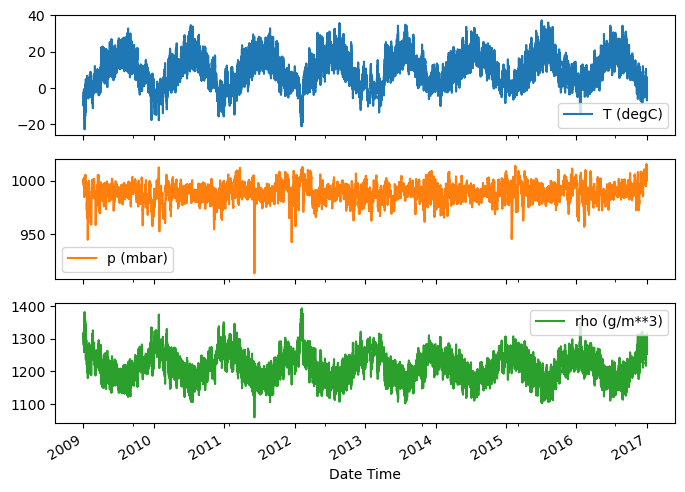

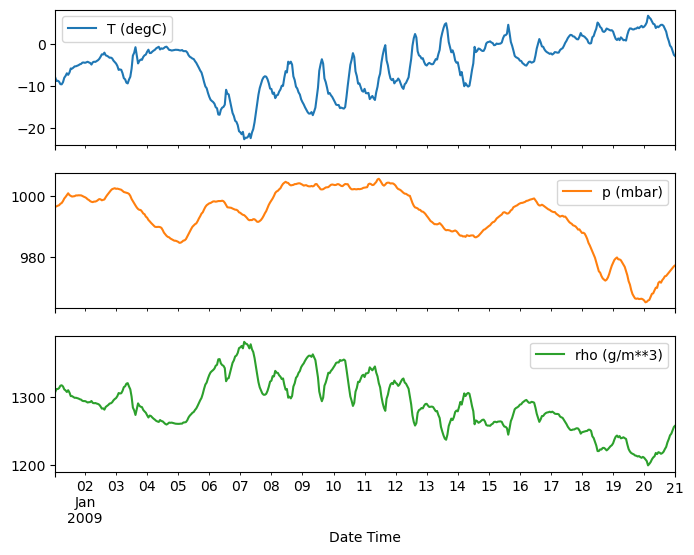

In [1503]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

# STEP 2: FEATURE ENGINEERING / DATA CLEANING / PRE-PROCESSING TECHNIQUES

## Label your target variable

In [1504]:
# Ex) Change "yes" or "no" to 1 or 0 so the model understands the label

## Fix the data imbalance and other problems from STEP 1

## Seperate features (x) from labels (y)

## Feature Reduction

## Normalize / Scale the Data

## Investigate Variance or Feature Importance

# STEP 3: MODEL TRAINING & BUILDING


## Split into Train and Test data

## Use a Model

## Perform a Hyperparameter Search

## Save the best model

# STEP 4: EVALUATE THE MODEL

## Look at Metrics - Ex) Precision, Recall, F1 score

## Plot a Confusion Matrix

# STEP 5: DEPLOY MODEL